#### This notebook takes the raw data from the API and processes it to the modeling data.

#### 2) Calculate moving averages, percent changes, and z-scores for the 21 ticker symbols across 3 rolling window sizes. These are written to interim data as "processed" individual csv files.
#### 3) Histograms were generated for means of z-scores. Four of the original 25 tickers were removed based on unusual z-scores or volume data issues. JNK was removed due to weirdly high open z-score mean, HYG was removed due to weirdly low low z-score mean, and EWZ/IEF had volume data isses (infinite end values).
#### 4) Pull, standardize, and merge all available daily and hourly technical indicator data for the two symbols with the respective OHLC datasets by date or time.
#### 5) Concatenate the four datasets for each rolling window.

In [223]:
import pandas as pd
from os import listdir
from os.path import isfile, join

In [224]:
window_sizes = [5, 10, 20]

def zscore(x, window):
    r = x.rolling(window=window)
    m = r.mean().shift(1)
    s = r.std(ddof=0).shift(1)
    z = (x-m)/s
    return z

In [225]:
onlyfiles = [f for f in listdir('../data/raw/') if isfile(join('../data/raw/', f))]
onlyfiles = list(filter(lambda thisfilename: '_daily.csv' in thisfilename, onlyfiles))

ticker_stats_mean = pd.DataFrame()
ticker_stats_std = pd.DataFrame()

for filename in onlyfiles:
    ticker = filename.split('_')[0]
    
    # import csv, sort by date so percent change works, drop unneeded columns,
    # rename columns, calculate moving averages, calulate percent changes, drop na's
    df = pd.read_csv(f"../data/raw/{ticker}_daily.csv")
    df.sort_index(inplace=True, ascending=False)
    df = df.drop(['Unnamed: 0','5. adjusted close', '7. dividend amount', '8. split coefficient','SMA','EMA'], axis=1)
    df.columns = ['open','high','low','close','volume','rsi']

    # moving averages
    df['sma'] = df.iloc[:,3].rolling(window=50).mean()/df.iloc[:,3]
    df['ema'] = df.iloc[:,3].ewm(span=21).mean()/df.iloc[:,3]

    # percent change
    df['open'] = df['open'].pct_change()
    df['high'] = df['high'].pct_change()
    df['low'] = df['low'].pct_change()
    df['close'] = df['close'].pct_change()
    df['volume'] = df['volume'].pct_change()
    df = df.dropna()

    # zscore
    df['open'] =zscore(df['open'], window=window_size)
    df['high'] = zscore(df['high'], window=window_size)
    df['low'] = zscore(df['low'], window=window_size)
    df['close'] = zscore(df['close'], window=window_size)
    df['volume'] = zscore(df['volume'], window=window_size)
    df['rsi'] = zscore(df['rsi'], window=window_size)
    df['sma'] = zscore(df['sma'], window=window_size)
    df['ema'] = zscore(df['ema'], window=window_size)
    df = df.dropna()

    # ticker mean stats
    temp = pd.DataFrame(df.describe()).iloc[1:2,]
    temp['ticker'] = ticker
    ticker_stats_mean = pd.concat([ticker_stats_mean, temp])
    ticker_stats_mean.to_csv('../data/interim/ticker_stats_mean.csv')
    
    # ticker std stats
    temp = pd.DataFrame(df.describe()).iloc[2:3,]
    temp['ticker'] = ticker
    ticker_stats_std = pd.concat([ticker_stats_std, temp])
    ticker_stats_std.to_csv('../data/interim/ticker_stats_std.csv')

    # write data and describe to csv
    df.to_csv(f"../data/interim/{ticker}_processed.csv")
    df.describe().to_csv(f"../data/interim/{ticker}_describe.csv")
    print(f"{ticker} processed")

BND processed
EEM processed
EFA processed
FXI processed
GDX processed
IEMG processed
IWM processed
JETS processed
LQD processed
QQQ processed
SLV processed
SPY processed
TLT processed
VWO processed
XLB processed
XLE processed
XLF processed
XLI processed
XLK processed
XLU processed
XLV processed


array([[<AxesSubplot:title={'center':'ema'}>]], dtype=object)

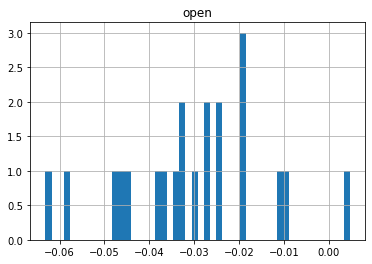

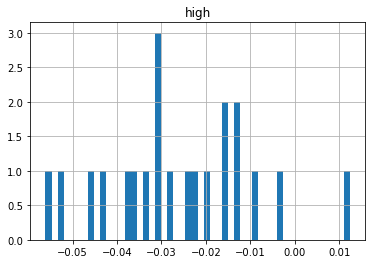

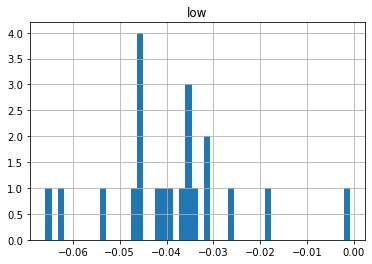

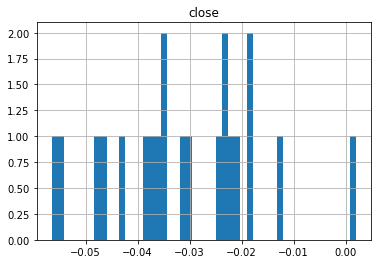

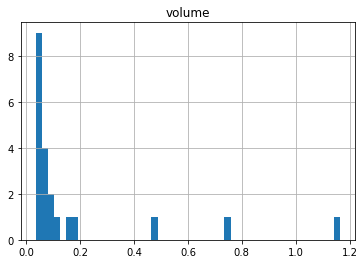

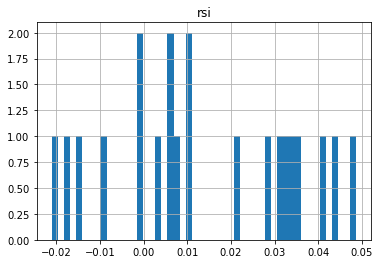

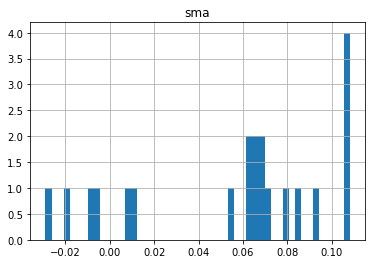

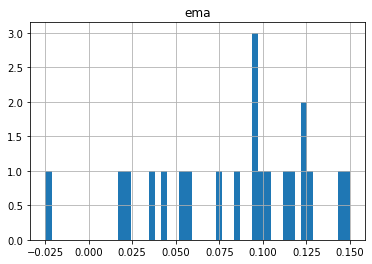

In [226]:
ticker_stats_mean.hist(column='open', bins=50)
ticker_stats_mean.hist(column='high', bins=50)
ticker_stats_mean.hist(column='low', bins=50)
ticker_stats_mean.hist(column='close', bins=50)
ticker_stats_mean.hist(column='volume', bins=50)
ticker_stats_mean.hist(column='rsi', bins=50)
ticker_stats_mean.hist(column='sma', bins=50)
ticker_stats_mean.hist(column='ema', bins=50)

In [228]:
# getting list of proccessed ticker files generated above
onlyfiles = [f for f in listdir('../data/interim/') if isfile(join('../data/interim/', f))]
onlyfiles = list(filter(lambda thisfilename: '_processed.csv' in thisfilename, onlyfiles))

# iterating through the window sizes provided in the list above
for window_size in window_sizes:
    print(f"starting window size: {window_size}")
    
    # iterating through the list of processed files
    for filename in onlyfiles:
        # empty dataframe for this ticker's flattened data
        flattened_df = pd.DataFrame()
        
        ticker = filename.split('_')[0]
        df = pd.read_csv(f"../data/interim/{ticker}_processed.csv").drop(['Unnamed: 0'], axis=1)
        
        # iterating through grouped rows (window size)
        for i in range(df.shape[0]-window_size+1):
            # resetting the index each time so column names align
            df_window = df.iloc[i:i+window_size,].reset_index(drop=True)
            # mapping the index as a string so it can be concatenated
            df_window.index = df_window.index.map(str)
            # unstacking the window to one row
            df_window = df_window.unstack().to_frame().sort_index(level=1).T
            # renaming the columns
            df_window.columns = df_window.columns.map('_'.join)
            # concatenating the flattened row to the dataframe
            flattened_df = pd.concat([flattened_df, df_window], axis=0)
        
        # writing the flattened dataframe for this ticker and window size to csv
        flattened_df.to_csv(f"../data/interim/{ticker}_{window_size}_flattened.csv")
        print(f"{ticker} {window_size} flattened")
    
    # getting list of flattened ticker files generated above for this window size
    onlyfiles_flattened = [f for f in listdir('../data/interim/') if isfile(join('../data/interim/', f))]
    onlyfiles_flattened = list(filter(lambda thisfilename: f"{window_size}_flattened.csv" in thisfilename, onlyfiles_flattened))
    
    # creating an empty dataframe for the combined flattened data
    all_data_combined = pd.DataFrame()

    # iterating through the list of flattened files for this window size and concatenating them to the dataframe
    for filename in onlyfiles_flattened:
        ticker = filename.split('_')[0]
        all_data_combined = pd.concat([all_data_combined, pd.read_csv(f"../data/interim/{ticker}_{window_size}_flattened.csv").drop(['Unnamed: 0'], axis=1)])
    
    all_data_combined = all_data_combined.drop([f"volume_{window_size-1}", f"rsi_{window_size-1}", f"sma_{window_size-1}", f"ema_{window_size-1}"], axis=1)
    
    # writing the combined flattened dataframe for this window size to csv in the processed folder    
    all_data_combined.to_csv(f"../data/processed/all_processed_{window_size}.csv")
    print(f"window {window_size} data combined")
    print(all_data_combined.shape)


starting window size: 5
BND 5 flattened
EEM 5 flattened
EFA 5 flattened
FXI 5 flattened
GDX 5 flattened
IEMG 5 flattened
IWM 5 flattened
JETS 5 flattened
LQD 5 flattened
QQQ 5 flattened
SLV 5 flattened
SPY 5 flattened
TLT 5 flattened
VWO 5 flattened
XLB 5 flattened
XLE 5 flattened
XLF 5 flattened
XLI 5 flattened
XLK 5 flattened
XLU 5 flattened
XLV 5 flattened
window 5 data combined
(96303, 36)
starting window size: 10
BND 10 flattened
EEM 10 flattened
EFA 10 flattened
FXI 10 flattened
GDX 10 flattened
IEMG 10 flattened
IWM 10 flattened
JETS 10 flattened
LQD 10 flattened
QQQ 10 flattened
SLV 10 flattened
SPY 10 flattened
TLT 10 flattened
VWO 10 flattened
XLB 10 flattened
XLE 10 flattened
XLF 10 flattened
XLI 10 flattened
XLK 10 flattened
XLU 10 flattened
XLV 10 flattened
window 10 data combined
(96198, 76)
starting window size: 20
BND 20 flattened
EEM 20 flattened
EFA 20 flattened
FXI 20 flattened
GDX 20 flattened
IEMG 20 flattened
IWM 20 flattened
JETS 20 flattened
LQD 20 flattened
QQQ

In [ ]:
#window 5: 96303 rows, 36 columns (32 features, 4 targets)
#window 10: 96198 rows, 76 columns (72 features, 4 targets)
#window 20: 95988 rows, 156 columns (152 features, 4 targets)

# from 5 to 10, losing 5 rows per ticker, so with 21 tickers, 21 *5 = 105 rows lost
# from 10 to 20, losing an additional 10 rows per ticker, so 21 *10 = 210 rows lost (315 total)